# **If Monet and Cézanne Visited Yosemite**
------------------

------------------------------------------------------------------------------
** **Do not run!** This notebook is set up to run in Google Collab with my google drive connected. I have annotated this notebook but also look at accompanying Jupyter Notebook for more writeup about results. **

______________________________________________________________________________

This project is to generate images of Yosemite National Park in the painting style of Claud Monet and Paul Cézanne. The model doesn't produce an entirely new image, instead bases an already existing image of Yosemite, and produces one image in the style of Monet, and one image in the style of Cézanne. The datasets used are all datasets provided from Tensorflow. All three datasets are over 500 instances, and the Yosemite and Monet datasets are over 1000 instances. They are all .jpg images, 256x256 in size. 

The program uses a CycleGAN architecture to apply the Monet/Cézanne painting style to the Yosemite photos. To begin, split the datasets into a 10/90 test/training split. Go through all images in the training sets and randomly flip, crop and jitter them. Jittering the image just moves the image around a bit. Those processes are shown below with examples shown after. This editing helps the program better determine the underlying styles of the artists. 

CycleGAN uses an architecture of two Generators. This notebook uses 2 sepereate CycleGAN's, one per artist, for a total of 4 generators. For each CycleGAN, one generator produces a fake Yosemite photo, then the other generator takes that photo and tries to edit it back to the original real photo. For example, Generator G and Generator H exist, real photo X exists. G(X) = Y, then F(Y) ~= X. So F(G(X)) ~= X. These generators produce their photos for the discriminators to classify which photo is real, between the real image and the generated image. By the generators and discriminators working in competition to each other, they both improve in a zero-sum game. 

The generator is a modified U-Net architecture. Started with generator from this research paper https://arxiv.org/pdf/1611.07004.pdf. Here is a photo of the architecture https://drive.google.com/file/d/1hxK0cQ7Rbf2wTJpYYQ6_MuPzvNuuHzDl/view?usp=sharing.

The discriminator is a PatchGAN Architecture. Used from Pix2Pix library. Here is the architecture https://drive.google.com/file/d/1j0yPOECfQANUhh8tLGGhvW3EPPuU1uR2/view?usp=sharing.

The training generates an image, then runs it against the discriminator. Based off of those results, it produces the accuracy of the generator and discriminator and applies that loss to the gradients of the the generator and discriminator. I have it set to 10 epochs right now, but that is not enough. Currently, each epoch runs both CycleGAN's once, overall taking just about 8min/epoch using Google Colab GPU. The generators and discriminators are saved after 5 epochs. Running two CycleGANs for Monet and Cezanne took the  same time as it took just to run one CycleGAN for only Monet, so there is insignificant added time to training a second CycleGAN for Cézanne's style. The longest I have run it for so far is about 10 epochs, but I plan to run it for 12 hours, hopefully getting 75 epochs in, so I can see the results. << Update. Most epochs for one model trained was 185 epochs.

I would like to see if I can reduce this time per epoch to make it faster at training. I might think about changing the crop of the image to 128x128 pixels, thinking that might make it faster to train. Obviously 256x256 is not HD, so I am not worrying about the resolution of the images produced. I might also go edit the generator and discriminator to see if I can sacrifice any amount of accuracy for speed. I also plan to add another CycleGAN to produce Van Gogh styled images. << Update. Could not decrease time per epochs.



In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

Downloading the Monet, Cezanne and Yosemite datasets from Tensorflow's libraries

In [5]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True)

train_monet = dataset['trainA']
test_monet = dataset['testA']


dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',
                              with_info=True, as_supervised=True)

train_summer = dataset['trainA']
test_summer = dataset['testA']

dataset, metadata = tfds.load('cycle_gan/cezanne2photo',
                              with_info=True, as_supervised=True)

train_cezanne = dataset['trainA']
test_cezanne = dataset['testA']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYDCNJ5/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYDCNJ5/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYDCNJ5/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteYDCNJ5/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteW3KVJS/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteW3KVJS/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteW3KVJS/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteW3KVJS/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0. Subsequent calls will reuse this data.


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteJR17B4/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteJR17B4/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteJR17B4/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0.incompleteJR17B4/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/cezanne2photo/2.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

# Pre-processing of the images

Pre-processing of the images in all 3 datasets provided by Tensorflow. These methods crop all images to the same dimensions, randomly mirror the images and randomly "jitter" the crop around the image. This helps by creating a somewhat randomized foundation for training to avoid overfitting.

In [12]:
train_summer = train_summer.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_monet = train_monet.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_cezanne = train_cezanne.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_summer = test_summer.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_cezanne = test_cezanne.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [13]:
sample_summer = next(iter(train_summer))
sample_monet = next(iter(train_monet))
sample_cezanne = next(iter(train_cezanne))

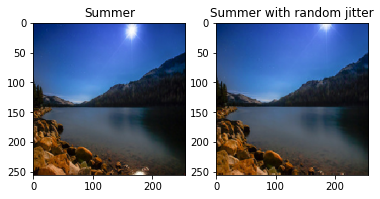

In [14]:
plt.subplot(121)
plt.title('Summer')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Summer with random jitter')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

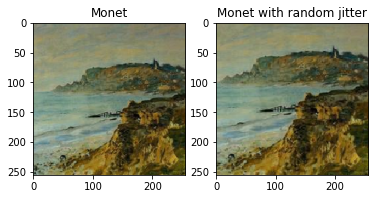

In [15]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

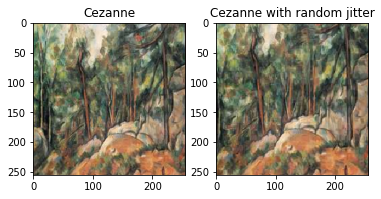

In [16]:
plt.subplot(121)
plt.title('Cezanne')
plt.imshow(sample_cezanne[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Cezanne with random jitter')
plt.imshow(random_jitter(sample_cezanne[0]) * 0.5 + 0.5)

## Generators

The generators are based on a U-Net structure from this research paper https://arxiv.org/abs/1611.07004. There is are 2 seperate generators for each Monet and Cezanne. They train and learn all seperately. I kept the same structure of the generator, from the research paper. To edit the training results I changed weights in the loss functions and optimizers below.

In [17]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [18]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [19]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [20]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Creating the generators. Generators g and f train with the Monet dataset, generators p and q train with the Cezanne dataset.

In [21]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_p = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_q = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')


discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_a = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_b = pix2pix.discriminator(norm_type='instancenorm', target=False)

First step of generators attempting to create Monet and Cezanne images out of Yosemite images and vice versa. As you can see, the images produced are very pixelated. The discriminator will easily discrimate those images as the fake images. The generators will improve and will fool the discriminator models soon.

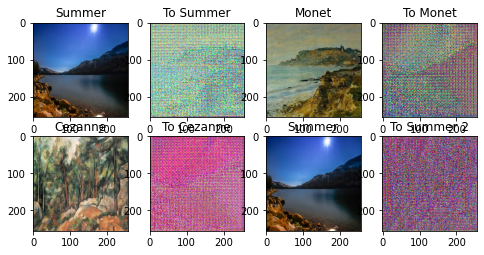

In [22]:
to_monet = generator_g(sample_summer)
to_summer = generator_f(sample_monet)
to_cezanne = generator_p(sample_summer)
to_summer_2 = generator_q(sample_cezanne)

plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_summer, to_summer, sample_monet, to_monet, sample_cezanne, to_cezanne, sample_summer, to_summer_2]
title = ['Summer', 'To Summer', 'Monet', 'To Monet', 'Cezanne', 'To Cezanne', 'Summer', 'To Summer 2']

for i in range(len(imgs)):
  plt.subplot(4, 4, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

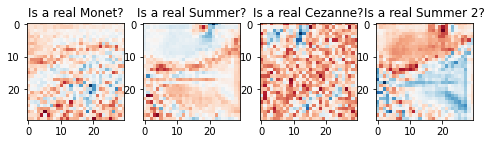

In [23]:
plt.figure(figsize=(8, 8))

plt.subplot(141)
plt.title('Is a real Monet?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(142)
plt.title('Is a real Summer?')
plt.imshow(discriminator_x(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.subplot(143)
plt.title('Is a real Cezanne?')
plt.imshow(discriminator_a(sample_cezanne)[0, ..., -1], cmap='RdBu_r')

plt.subplot(144)
plt.title('Is a real Summer 2?')
plt.imshow(discriminator_b(sample_summer)[0, ..., -1], cmap='RdBu_r')

plt.show()

After training on the many images, the generators will start to fool the dicriminators. When that happens, the dicriminators will also improve and force the generators to improve more. 

## Loss functions

In [24]:
LAMBDA = 10

^^^^ After testing, LAMBDA = 10 is still the best lambda to use. 

In [25]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [27]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [28]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [29]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

I intialized the Adam class optimzers from Keras with learning rate = 0.0004 and beta_1 = 0.4. I opted for a larger learning rate than the paper suggests (0.0004 vs 0.0002) because I believe the images in the style of paintings do not require to maintain acute details of real life. The goal of this is not to create a life-like image, but instead a painting, which does not resemble the details of life. I felt it was a change that would improve the training time more than degrade the quality results.

In [30]:
generator_g_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
generator_f_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
generator_p_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
generator_q_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)

discriminator_x_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
discriminator_y_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
discriminator_a_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)
discriminator_b_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.4)

## Checkpoints

Checkpoints to help with training. Saved to my google drive in incriments of 5 epochs. I had a big problem with Google Collab randomly disconnecting and losing all my progress so this helped with keeping my progress in training my models. Saves all 4 generators, discrimnators and optimizers.

In [31]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           generator_p=generator_p,
                           generator_q=generator_q,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           discriminator_a=discriminator_a,
                           discriminator_b=discriminator_b,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           generator_p_optimizer=generator_p_optimizer,
                           generator_q_optimizer=generator_q_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer,
                           discriminator_a_optimizer=discriminator_a_optimizer,
                           discriminator_b_optimizer=discriminator_b_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)




# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


The # of epochs I would run in a training session. The epochs would take around 8 minutes (+/- a few seconds). To stay within the 12 hour limitaion of Collab, I would run maximum of 70 epochs over night.

In [35]:
EPOCHS = 70

Produces an image based on the trained generators. Shows both the Yosemite input image and the outputted Monet/Cezanne image.

In [36]:
def generate_images(model, test_input, style, count, train):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  if style == 'monet':
    title = ['Input Image', 'Predicted Monet Image']
  else:
    title = ['Input Image', 'Predicted Cezanne Image']

  

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  path = str('/content/drive/MyDrive/Colab Notebooks/'+str(count)+style+train+'.png')
  print(path)
  plt.savefig(path)
  plt.show()
  

Training step initially from Tensorflow library, modified to run with multiple datasets.

In [37]:
@tf.function
def train_step_monet(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Seperate training step for Monet models and Cezanne Models.

In [38]:
@tf.function
def train_step_cezanne(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator P translates X -> Y
    # Generator Q translates Y -> X.
    
    fake_y = generator_p(real_x, training=True)
    cycled_x = generator_q(fake_y, training=True)

    fake_x = generator_q(real_y, training=True)
    cycled_y = generator_p(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_q(real_x, training=True)
    same_y = generator_p(real_y, training=True)

    disc_real_x = discriminator_a(real_x, training=True)
    disc_real_y = discriminator_b(real_y, training=True)

    disc_fake_x = discriminator_a(fake_x, training=True)
    disc_fake_y = discriminator_b(fake_y, training=True)

    # calculate the loss
    gen_p_loss = generator_loss(disc_fake_y)
    gen_q_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_p_loss = gen_p_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_q_loss = gen_q_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_a_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_b_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_p_gradients = tape.gradient(total_gen_p_loss, 
                                        generator_p.trainable_variables)
  generator_q_gradients = tape.gradient(total_gen_q_loss, 
                                        generator_q.trainable_variables)
  
  discriminator_a_gradients = tape.gradient(disc_a_loss, 
                                            discriminator_a.trainable_variables)
  discriminator_b_gradients = tape.gradient(disc_b_loss, 
                                            discriminator_b.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_p_optimizer.apply_gradients(zip(generator_p_gradients, 
                                            generator_p.trainable_variables))

  generator_q_optimizer.apply_gradients(zip(generator_q_gradients, 
                                            generator_q.trainable_variables))
  
  discriminator_a_optimizer.apply_gradients(zip(discriminator_a_gradients,
                                                discriminator_a.trainable_variables))
  
  discriminator_b_optimizer.apply_gradients(zip(discriminator_b_gradients,
                                                discriminator_b.trainable_variables))

The actual code for running all training, generating in progress images and calling for checkpoints. 

/content/drive/MyDrive/Colab Notebooks/56monetTrain.png


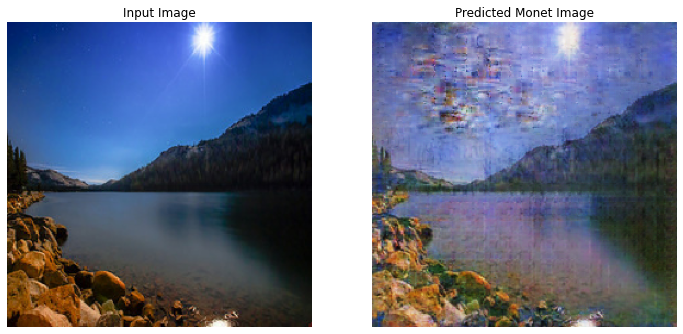

/content/drive/MyDrive/Colab Notebooks/56cezanneTrain.png
Buffered data was truncated after reaching the output size limit.

In [39]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y, image_z in tf.data.Dataset.zip((train_summer, train_monet, train_cezanne)):
    train_step_monet(image_x, image_y)
    train_step_cezanne(image_x, image_z)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_summer, 'monet', epoch, 'Train')
  generate_images(generator_p, sample_summer, 'cezanne', epoch, 'Train')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

After training for specified epochs, take 10 images from Yosemite dataset and apply Monet and Cezanne models to the images. Show and save images.

In [40]:
# Run the trained model on the test dataset
count = 0
for inp in test_summer.take(10):
  generate_images(generator_g, inp, 'monet', count, 'Test')
  generate_images(generator_p, inp, 'cezanne', count, 'Test')
  count= count + 1

Output hidden; open in https://colab.research.google.com to view.

# **Write Up**

Please see accompanying Jupyter Notebook for analysis of results.